In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtree
import numpy as np
import scipy

import optax
import functools

import haiku as hk
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import os
rngseed = 42
rngkeyseq = hk.PRNGSequence(jax.random.PRNGKey(rngseed))

In [2]:
def loss_fn(params, x, y):
    y_pred = forward.apply(params, None, x)
    return jnp.mean(optax.l2_loss(y_pred, y))

def log_prior(params):
    param_array, _ = jtree.tree_flatten(params)
    result = 0.0
    for param in param_array:
        result += dist.Normal(loc=prior_mean, scale=prior_std).log_prob(param).sum()
    return result

def log_likelihood(params, x, y, sigma=1.0):
    y_hat = forward.apply(params, None, x)
    ydist = dist.Normal(y_hat, sigma)
    return ydist.log_prob(y).sum()

def log_posterior(params, x, y, itemp=1.0):
    return itemp * log_likelihood(params, x, y) + log_prior(params)


def numpyro_model(X, Y, shapes, treedef, itemp=1.0, sigma=0.1, prior_mean=0.0, prior_std=1.0):
    param_dict = normal_prior(shapes, treedef, prior_mean=prior_mean, prior_std=prior_std)
    y_hat = forward.apply(param_dict, None, X)
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample("Y", dist.Normal(y_hat, sigma / jnp.sqrt(itemp)).to_event(1), obs=Y)
    return

def normal_prior(shapes, treedef, prior_mean=0.0, prior_std=1.0):
    result = []
    for i, shape in enumerate(shapes):
        result.append(numpyro.sample(str(i), dist.Normal(loc=prior_mean, scale=prior_std), sample_shape=shape))
    return treedef.unflatten(result)


def normal_localising_prior(params_center, std):
    result = []
    param_flat, treedef = jtree.tree_flatten(params_center)
    for i, p in enumerate(param_flat):
        result.append(numpyro.sample(str(i), dist.Normal(loc=p, scale=std)))
    return treedef.unflatten(result)


def expected_nll(param_list, X, Y, sigma):
    nlls = []
    for param in param_list:
        nlls.append(-log_likelihood(param, X, Y, sigma=sigma))
    return np.mean(nlls)

In [3]:
%time 

w_0 = [
    jnp.array([[0.1, 0.2, 0.01]]), 
    jnp.array([[0.02, -0.1, 0.5]]).T
]
input_dim, num_hidden_nodes = w_0[0].shape
output_dim = w_0[1].shape[1]
activation_fn = jax.nn.tanh

@hk.transform
def forward(x):
    mlp = hk.nets.MLP(
        [num_hidden_nodes, output_dim], # WARNING: there are global variables 
        activation=activation_fn, 
        w_init=w_initialiser,
        with_bias=False
    )
    return mlp(x)


sigma = 0.1
prior_std = 1.0
prior_mean = 0.0
w_initialiser = hk.initializers.RandomNormal(stddev=prior_std, mean=prior_mean)
num_itemps = 6

X = jax.random.uniform(
    key=next(rngkeyseq), 
    shape=(3, input_dim), 
    minval=-2, 
    maxval=2
)
true_param = forward.init(next(rngkeyseq), X)
treedef = jtree.tree_structure(true_param)
true_param = treedef.unflatten(w_0)
true_param_flat, treedef = jtree.tree_flatten(true_param)
shapes = [p.shape for p in true_param_flat]
print(true_param)

num_warmup = 500
num_posterior_samples = 2000
num_chains = 4
thinning = 4
kernel = numpyro.infer.NUTS(numpyro_model)
mcmc = numpyro.infer.MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_posterior_samples,
    num_chains=num_chains,
    thinning=thinning, 
    progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
)

# ns = [50, 100, 200, 300, 500]
ns = [100, 500]
run_rec = {}
for num_training_data in ns:
    X = jax.random.uniform(
        key=next(rngkeyseq), 
        shape=(num_training_data, input_dim), 
        minval=-2, 
        maxval=2
    )
    y_true = forward.apply(true_param, next(rngkeyseq), X)
    Y = y_true + jax.random.normal(next(rngkeyseq), y_true.shape) * sigma
    n = num_training_data
    itemps = jnp.linspace(
        1 / jnp.log(n) * (1 - 1 / jnp.sqrt(2 * jnp.log(n))),
        1 / jnp.log(n) * (1 + 1 / jnp.sqrt(2 * jnp.log(n))), 
        num_itemps
    )
    print(f"itemps={itemps}")

    enlls = []
    for i_itemp, itemp in enumerate(itemps): 
        mcmc.run(
            next(rngkeyseq), 
            X, Y, 
            shapes, treedef,
            itemp=itemp, 
            sigma=sigma, 
            prior_mean=prior_mean,
            prior_std=prior_std, 
        )
        posterior_samples = mcmc.get_samples()
        num_mcmc_samples = num_mcmc_samples = len(posterior_samples[list(posterior_samples.keys())[0]])

        param_list = [
            [posterior_samples[name][i] for name in sorted(posterior_samples.keys())]
            for i in range(num_mcmc_samples)
        ]
        enll = expected_nll(map(treedef.unflatten, param_list), X, Y, sigma)
        enlls.append(enll)
        print(f"Finished {i_itemp} temp={1/itemp:.3f}. Expected NLL={enll:.3f}")
        if len(enlls) > 1:
            slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[:len(enlls)], enlls)
            print(f"est. RLCT={slope:.3f}, energy={intercept / n:.3f}, r2={r_val**2:.3f}")
    
    run_rec[num_training_data] = {
        "itemps": itemps, "enlls": enlls, "slope": slope, "intercept": intercept, "rval": r_val
    }
    print(f"Finished (n={num_training_data}): RLCT est={slope:.3f}, energy={intercept / n:.3f}")

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
{'mlp/~/linear_0': {'w': Array([[0.1 , 0.2 , 0.01]], dtype=float32)}, 'mlp/~/linear_1': {'w': Array([[ 0.02],
       [-0.1 ],
       [ 0.5 ]], dtype=float32)}}
itemps=[0.14559612 0.17421657 0.20283702 0.23145746 0.2600779  0.28869835]


/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_74711/671135828.py:46: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████████████████████████████████████| 2500/2500 [00:01<00:00, 1485.66it/s, 127 steps of size 2.56e-02. acc. prob=0.88]


Finished 0 temp=6.868. Expected NLL=-78.722


sample: 100%|██████████████████████████████████████████| 2500/2500 [00:01<00:00, 1414.49it/s, 127 steps of size 2.45e-02. acc. prob=0.92]


Finished 1 temp=5.740. Expected NLL=-79.261
est. RLCT=0.477, energy=-0.820, r2=1.000


sample: 100%|██████████████████████████████████████████| 2500/2500 [00:01<00:00, 1449.30it/s, 121 steps of size 2.52e-02. acc. prob=0.89]


Finished 2 temp=4.930. Expected NLL=-80.049
est. RLCT=0.672, energy=-0.833, r2=0.959


sample: 100%|██████████████████████████████████████████| 2500/2500 [00:01<00:00, 1446.03it/s, 127 steps of size 2.55e-02. acc. prob=0.88]


Finished 3 temp=4.320. Expected NLL=-80.537
est. RLCT=0.724, energy=-0.836, r2=0.976


sample: 100%|██████████████████████████████████████████| 2500/2500 [00:01<00:00, 1380.77it/s, 127 steps of size 2.09e-02. acc. prob=0.90]


Finished 4 temp=3.845. Expected NLL=-80.680
est. RLCT=0.694, energy=-0.834, r2=0.980


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:01<00:00, 1720.70it/s, 63 steps of size 2.75e-02. acc. prob=0.53]


Finished 5 temp=3.464. Expected NLL=-81.136
est. RLCT=0.715, energy=-0.835, r2=0.984
Finished (n=100): RLCT est=0.715, energy=-0.835
itemps=[0.11526922 0.13352601 0.1517828  0.17003958 0.18829636 0.20655315]


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:05<00:00, 485.28it/s, 111 steps of size 2.03e-02. acc. prob=0.82]


Finished 0 temp=8.675. Expected NLL=-458.494


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:05<00:00, 466.35it/s, 255 steps of size 1.90e-02. acc. prob=0.81]


Finished 1 temp=7.489. Expected NLL=-459.338
est. RLCT=0.711, energy=-0.929, r2=1.000


sample: 100%|████████████████████████████████████████████| 2500/2500 [00:06<00:00, 392.84it/s, 55 steps of size 1.46e-02. acc. prob=0.90]


Finished 2 temp=6.588. Expected NLL=-460.500
est. RLCT=0.948, energy=-0.933, r2=0.971


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:05<00:00, 451.64it/s, 255 steps of size 1.72e-02. acc. prob=0.83]


Finished 3 temp=5.881. Expected NLL=-460.999
est. RLCT=0.931, energy=-0.933, r2=0.985


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:05<00:00, 419.41it/s, 255 steps of size 1.58e-02. acc. prob=0.87]


Finished 4 temp=5.311. Expected NLL=-461.445
est. RLCT=0.908, energy=-0.933, r2=0.989


sample: 100%|███████████████████████████████████████████| 2500/2500 [00:06<00:00, 407.96it/s, 511 steps of size 1.52e-02. acc. prob=0.77]


Finished 5 temp=4.841. Expected NLL=-461.597
est. RLCT=0.857, energy=-0.932, r2=0.983
Finished (n=500): RLCT est=0.857, energy=-0.932


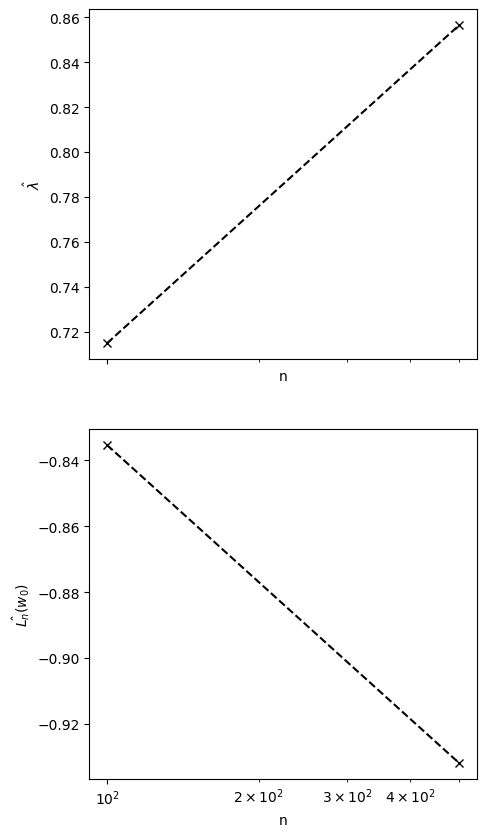

In [4]:
nums = sorted(run_rec.keys())
lambdas = [run_rec[n]["slope"] for n in nums]
energies = [run_rec[n]["intercept"] / n for n in nums]

fig, axes = plt.subplots(2, 1, figsize=(5, 10), sharex=True)
ax = axes[0]
ax.plot(nums, lambdas, "kx--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{\lambda}$")
ax.set_xscale("log")

ax = axes[1]
ax.plot(nums, energies, "kx--")
ax.set_xlabel("n")
ax.set_ylabel("$\hat{L_n}(w_0)$");
